In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torch.utils as utils
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

### TENSORBOARD WRITER

from datetime import datetime

DATA_ROOT_FOLDER = '/Users/brandon/Data/pytorch'

# run timestamp
ts = datetime.now().strftime('%Y%m%d_%H%M%S')

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'{DATA_ROOT_FOLDER}/runs/{ts}')


### DATA

batch_size=128

train_set = torchvision.datasets.FashionMNIST(root = f'{DATA_ROOT_FOLDER}/data', train = True, download = True, transform = transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = f'{DATA_ROOT_FOLDER}/data', train = False, download = True, transform = transforms.ToTensor())

train_val_split = [0.8, 0.2]
train_set, val_set = utils.data.random_split(train_set, [round(p * len(train_set)) for p in train_val_split])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

# class names
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


class MiniVggBnAfter(nn.Module):
    def __init__(self):
        super(MiniVggBnAfter, self).__init__()
        
        # first: CONV => RELU => CONV => RELU => POOL set
        self.conv1_1 = nn.Conv2d(1, 32, 3, padding = 1)
        self.norm1_1 = nn.BatchNorm2d(32)
    
        self.conv1_2 = nn.Conv2d(32, 32, 3, padding = 1)
        self.norm1_2 = nn.BatchNorm2d(32)
    
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        # second: CONV => RELU => CONV => RELU => POOL set
        self.conv2_1 = nn.Conv2d(32, 64, 3, padding = 1)
        self.norm2_1 = nn.BatchNorm2d(64)
    
        self.conv2_2 = nn.Conv2d(64, 128, 3, padding = 1)
        self.norm2_2 = nn.BatchNorm2d(128)
    
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        # fully connected (single) to RELU
        
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.normfc_1 = nn.BatchNorm1d(128)    
        self.dropoutfc_1 = nn.Dropout1d(0.20)
        
        self.fc2 = nn.Linear(128, 10)
        
        
    def forward(self, x):
        out = self.norm1_1(F.relu(self.conv1_1(x)))
        out = self.norm1_2(F.relu(self.conv1_2(out)))
        out = self.pool1(out)
        out = self.dropout1(out)
        
        out = self.norm2_1(F.relu(self.conv2_1(out)))
        out = self.norm2_2(F.relu(self.conv2_2(out)))
        out = self.pool2(out)
        out = self.dropout2(out)
        
        # flatten
        out = out.view(-1, 128 * 7 * 7)
        
        out = self.normfc_1(F.relu(self.fc1(out)))
        out = self.dropoutfc_1(out)
        
        out = self.fc2(out)
        
        # softmax classifier
        
        return out


model = MiniVggBnAfter()

# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)
model.to(device)
print(device)

loss_func = nn.CrossEntropyLoss()

initial_learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=initial_learning_rate, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

from torchinfo import summary
summary(model, input_size=(batch_size, 1, 28, 28), verbose=1, device=device);

mps
Layer (type:depth-idx)                   Output Shape              Param #
MiniVggBnAfter                           [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 28, 28]         320
├─BatchNorm2d: 1-2                       [128, 32, 28, 28]         64
├─Conv2d: 1-3                            [128, 32, 28, 28]         9,248
├─BatchNorm2d: 1-4                       [128, 32, 28, 28]         64
├─MaxPool2d: 1-5                         [128, 32, 14, 14]         --
├─Dropout2d: 1-6                         [128, 32, 14, 14]         --
├─Conv2d: 1-7                            [128, 64, 14, 14]         18,496
├─BatchNorm2d: 1-8                       [128, 64, 14, 14]         128
├─Conv2d: 1-9                            [128, 128, 14, 14]        73,856
├─BatchNorm2d: 1-10                      [128, 128, 14, 14]        256
├─MaxPool2d: 1-11                        [128, 128, 7, 7]          --
├─Dropout2d: 1-12                        [128, 128, 7, 7]          

/Users/brandon/anaconda3/envs/ee541_work/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Users/brandon/anaconda3/envs/ee541_work/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


In [3]:
num_epochs = 25
iter_count = 0
for epoch in range(num_epochs):  
    train_loss = 0.0
    train_acc = 0.0
    
    val_loss = 0.0
    val_acc = 0.0
    
    model.train()
    
    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1:02d}')):
        iter_count += 1
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)        
        loss = loss_func(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.data
        # https://github.com/pytorch/pytorch/issues/92311
        #train_acc += torch.sum(torch.eq(torch.argmax(outputs, axis=1), labels))
        train_acc += torch.sum(torch.eq(torch.max(outputs, axis=1).indices, labels))
    
        # ...log the running loss
        if i and not (i % 100):
            writer.add_scalar('Loss/train/100',
                            train_loss / i / len(labels),
                            len(train_loader.dataset) * epoch + i + 1)

            writer.add_scalar('Accuracy/train/100',
                            train_acc / i / len(labels),
                            len(train_loader.dataset) * epoch + i + 1)
    
    print('  * train  ' +
        f'Loss: {train_loss / len(train_loader.dataset):.4f}, ' +
        f'Accuracy: {100 * train_acc / len(train_loader.dataset):.3f}%, ' +
        f'LR: {optimizer.param_groups[0]["lr"]:.5f}')


    model.eval()
    
    for i, data in enumerate(val_loader, 0):
        with torch.no_grad():
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
                
            val_loss += loss.data
            val_acc += torch.sum(torch.eq(torch.max(outputs, axis=1).indices, labels))
            
    print('  * val    ' +
        f'Loss: {val_loss / len(val_loader.dataset):.4f}, ' +
        f'Accuracy: {100 * val_acc / len(val_loader.dataset):.3f}%')

    writer.add_scalar('Loss/val',
                    val_loss / len(val_loader.dataset),
                    epoch+1)

    writer.add_scalar('Accuracy/val',
                    val_acc / len(val_loader.dataset),
                    epoch+1)
        
    scheduler.step()
        

test_acc = 0.0
for i, data in enumerate(test_loader, 0):
    with torch.no_grad():
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        test_acc += torch.sum(torch.eq(torch.max(outputs, axis=1).indices, labels))
        #test_acc += torch.sum(torch.sum(torch.eq(torch.argmax(outputs, axis=1), labels).long()))
        
print('  * test    ' +
    f'Accuracy: {100 * test_acc / len(test_loader.dataset):.3f}%')

# record accuracy
writer.add_scalar('test acc',
                test_acc / len(test_loader.dataset),
                epoch+1)

torch.save(model.state_dict(), './fashion_mnist_cnn.pth')
#copy = torch.load('./model.pth');

print('Finished Training')

Epoch 01:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0071, Accuracy: 66.590%, LR: 0.00100
  * val    Loss: 0.0031, Accuracy: 87.175%


Epoch 02:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0058, Accuracy: 72.094%, LR: 0.00090
  * val    Loss: 0.0025, Accuracy: 89.133%


Epoch 03:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0055, Accuracy: 73.502%, LR: 0.00081
  * val    Loss: 0.0023, Accuracy: 90.192%


Epoch 04:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0053, Accuracy: 74.308%, LR: 0.00073
  * val    Loss: 0.0021, Accuracy: 90.675%


Epoch 05:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0052, Accuracy: 74.688%, LR: 0.00066
  * val    Loss: 0.0020, Accuracy: 91.225%


Epoch 06:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0051, Accuracy: 75.156%, LR: 0.00059
  * val    Loss: 0.0020, Accuracy: 91.217%


Epoch 07:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0050, Accuracy: 75.360%, LR: 0.00053
  * val    Loss: 0.0019, Accuracy: 91.542%


Epoch 08:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0050, Accuracy: 75.415%, LR: 0.00048
  * val    Loss: 0.0019, Accuracy: 91.583%


Epoch 09:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0050, Accuracy: 75.623%, LR: 0.00043
  * val    Loss: 0.0019, Accuracy: 91.733%


Epoch 10:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0049, Accuracy: 76.152%, LR: 0.00039
  * val    Loss: 0.0018, Accuracy: 91.933%


Epoch 11:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0049, Accuracy: 76.304%, LR: 0.00035
  * val    Loss: 0.0018, Accuracy: 91.850%


Epoch 12:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0048, Accuracy: 76.629%, LR: 0.00031
  * val    Loss: 0.0018, Accuracy: 92.167%


Epoch 13:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0048, Accuracy: 76.512%, LR: 0.00028
  * val    Loss: 0.0017, Accuracy: 92.242%


Epoch 14:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0048, Accuracy: 76.558%, LR: 0.00025
  * val    Loss: 0.0017, Accuracy: 92.217%


Epoch 15:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0047, Accuracy: 76.840%, LR: 0.00023
  * val    Loss: 0.0017, Accuracy: 92.292%


Epoch 16:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0048, Accuracy: 76.665%, LR: 0.00021
  * val    Loss: 0.0017, Accuracy: 92.425%


Epoch 17:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0047, Accuracy: 77.277%, LR: 0.00019
  * val    Loss: 0.0017, Accuracy: 92.342%


Epoch 18:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0047, Accuracy: 76.919%, LR: 0.00017
  * val    Loss: 0.0017, Accuracy: 92.458%


Epoch 19:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0047, Accuracy: 77.281%, LR: 0.00015
  * val    Loss: 0.0017, Accuracy: 92.433%


Epoch 20:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0047, Accuracy: 77.225%, LR: 0.00014
  * val    Loss: 0.0017, Accuracy: 92.542%


Epoch 21:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0047, Accuracy: 77.060%, LR: 0.00012
  * val    Loss: 0.0016, Accuracy: 92.500%


Epoch 22:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0047, Accuracy: 77.308%, LR: 0.00011
  * val    Loss: 0.0016, Accuracy: 92.600%


Epoch 23:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0046, Accuracy: 77.423%, LR: 0.00010
  * val    Loss: 0.0016, Accuracy: 92.533%


Epoch 24:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0046, Accuracy: 77.319%, LR: 0.00009
  * val    Loss: 0.0016, Accuracy: 92.467%


Epoch 25:   0%|          | 0/375 [00:00<?, ?it/s]

  * train  Loss: 0.0046, Accuracy: 77.583%, LR: 0.00008
  * val    Loss: 0.0016, Accuracy: 92.525%
  * test    Accuracy: 92.050%
Finished Training


In [4]:
# HELPER FUNCTIONS

# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        

def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints with labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]


def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)    
    output = output.cpu()
    
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    
    images = images.cpu()
    
    # plot the images in the batch, along with predicted and true labels    
    fig = plt.figure(figsize=(12, 12))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig


def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()
    


In [9]:
### TENSORBOARD MODEL

dataiter = iter(train_loader)
images, labels = next(dataiter)

images = images.to(device)
writer.add_graph(model, images)

Overall accuracy: 92.05%


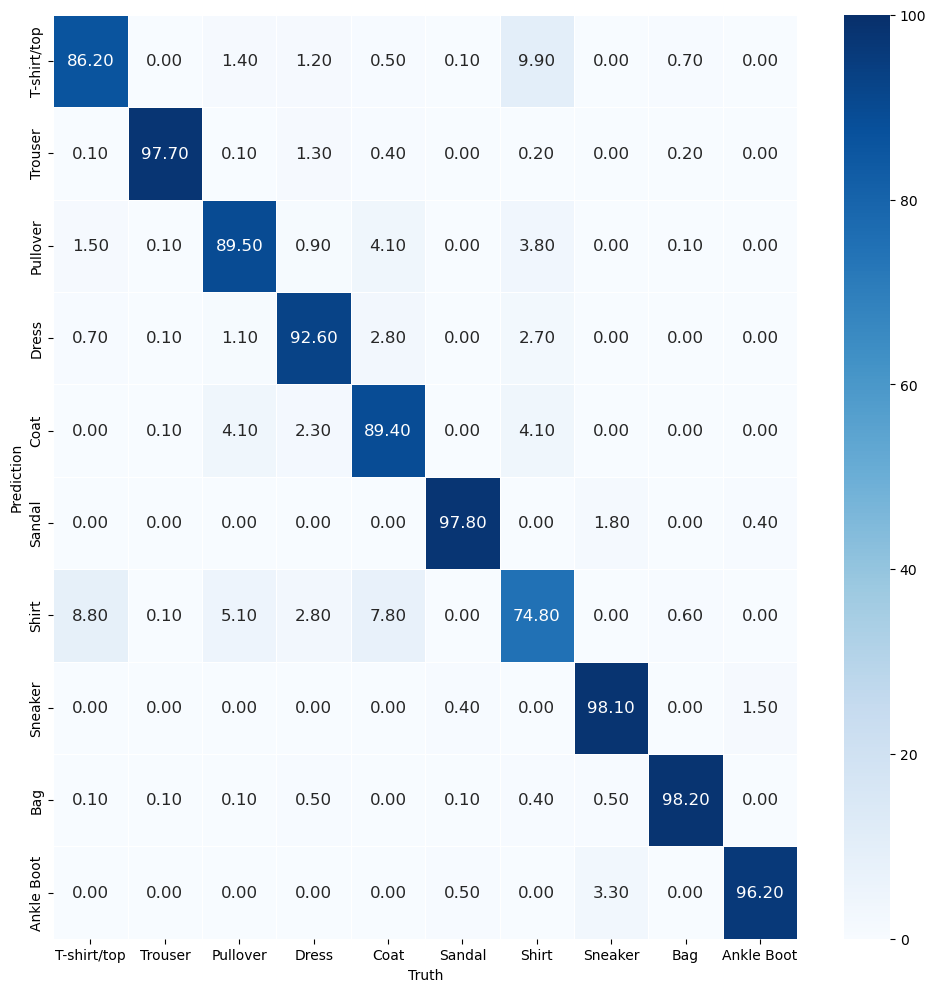

In [10]:
# TEST FINAL MODEL
# CONFUSION MATRIX

import pandas as pd
import seaborn as sn

confusion_matrix = np.zeros((10, 10))
class_count = np.zeros((10))

for i, data in enumerate(test_loader, 0):
    with torch.no_grad():
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        for t, p in zip(labels, preds):
            confusion_matrix[t, p] += 1
            class_count[t.long()] += 1

correct = sum([confusion_matrix[i,i] for i in range(10)])
print(f'Overall accuracy: {100*correct/sum(class_count):.2f}%')
            
plt.figure(figsize=[12,12])
df = pd.DataFrame(100 * confusion_matrix / class_count)
ax = sn.heatmap(df, vmin=0, vmax=100, cmap='Blues', annot=True, fmt='.2f', annot_kws={"size":12}, linewidths=0.5, 
               xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Truth')
ax.set_ylabel('Prediction')
plt.show()